In [1]:
#!pip install tensorflow pandas --quiet
#!pip install matplotlib

# check to see if it works on new machine

In [2]:

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
# Step 2: Load Dataset
df = pd.read_csv("15K_Names_Dataset_MLTraining.csv")
df.head()

,Name,Gender
0,James,M
1,John,M
2,Robert,M
3,Michael,M
4,William,M


In [4]:
# Step 3: Basic Data Exploration
print(df.info())
print(df['Gender'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    15000 non-null  object
 1   Gender  15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB
None
Gender
F    9006
M    5994
Name: count, dtype: int64


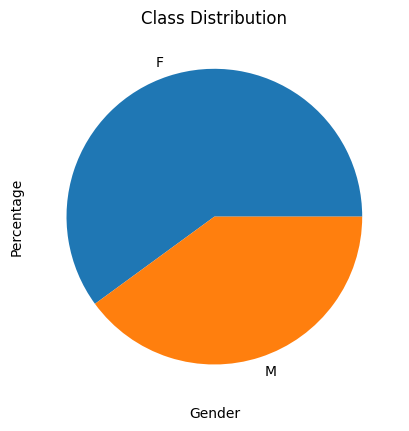

In [5]:
# display the class distribution
df['Gender'].value_counts(normalize=True) * 100

df['Gender'].value_counts(normalize=True).plot(kind='pie', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [6]:
# We need 50% distribution for both classes
print(df)
# Split by class
df_male = df[df['Gender'] == 'M']
df_female = df[df['Gender'] == 'F']

print(df_male)
print(df_female)

# Undersample female to match male
df_female_balanced = df_female.sample(n=len(df_male), random_state=42)

print(df_female_balanced)

# Combine
df_balanced = pd.concat([df_male, df_female_balanced]).sample(frac=1, random_state=42)  # shuffle
# display the class distribution
df_balanced['Gender'].value_counts(normalize=True) * 100

           Name Gender
0         James      M
1          John      M
2        Robert      M
3       Michael      M
4       William      M
...         ...    ...
14995  Euphemia      F
14996    Gordon      F
14997    Kaylon      F
14998  Kennadie      F
14999    Lynnda      F

[15000 rows x 2 columns]
           Name Gender
0         James      M
1          John      M
2        Robert      M
3       Michael      M
4       William      M
...         ...    ...
14977     Rikki      M
14987  Demetrus      M
14988    Dillen      M
14989     Izell      M
14990       Moe      M

[5994 rows x 2 columns]
            Name Gender
5           Mary      F
14     Elizabeth      F
15      Patricia      F
16      Jennifer      F
19         Linda      F
...          ...    ...
14995   Euphemia      F
14996     Gordon      F
14997     Kaylon      F
14998   Kennadie      F
14999     Lynnda      F

[9006 rows x 2 columns]
           Name Gender
14504     Azlyn      F
11006  Christyn      F
12549   Nikkole

Gender
M    50.0
F    50.0
Name: proportion, dtype: float64

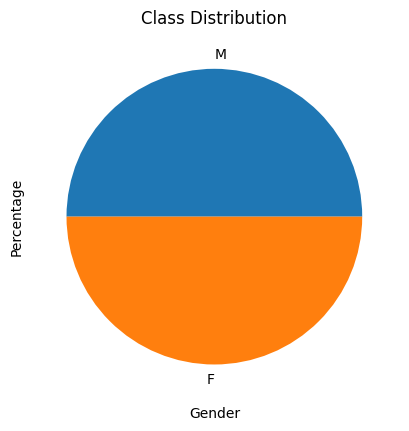

In [7]:
df_balanced['Gender'].value_counts(normalize=True).plot(kind='pie', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [8]:
#Optional: resize the dataset to 5000 rows for faster training
#df_balanced = df_balanced.sample(n=5000, random_state=42).reset_index(drop=True)

In [9]:
# Step 4: Preprocessing - cleanup
# Drop any rows with missing values
df_balanced = df_balanced.dropna(subset=["Name", "Gender"])

# Normalize case
df_balanced['Name'] = df_balanced['Name'].str.strip().str.lower()
df_balanced['Gender'] = df_balanced['Gender'].str.strip().str.upper()

# Filter only 'male' and 'female'
df_balanced = df_balanced[df_balanced['Gender'].isin(['M', 'F'])]

print(df_balanced)
print(df_balanced.shape) #initial shape: 15000 rows, 2 columns

          Name Gender
3613    brandt      M
7924   aminata      F
3002   journee      F
10249    blima      F
1232   gustavo      M
...        ...    ...
6183   angelyn      F
12935   dupree      M
13444    navin      M
1993      aldo      M
3852   kyndall      F

[11988 rows x 2 columns]
(11988, 2)


In [10]:
# Step 4: Preprocessing - encode/tokenize
names = df_balanced['Name'].astype(str).values
genders = df_balanced['Gender'].values

# Encode gender labels to 0/1
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(genders)

# Tokenize names (character-level)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(names)
sequences = tokenizer.texts_to_sequences(names)

# Pad sequences
maxlen = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=maxlen)
y = np.array(labels)


In [11]:
print(df_balanced)
print (df_balanced.shape)
print(X.shape, y.shape)
print(X)
print(y)

          Name Gender
3613    brandt      M
7924   aminata      F
3002   journee      F
10249    blima      F
1232   gustavo      M
...        ...    ...
6183   angelyn      F
12935   dupree      M
13444    navin      M
1993      aldo      M
3852   kyndall      F

[11988 rows x 2 columns]
(11988, 2)
(11988, 14) (11988,)
[[ 0  0  0 ...  3 11  9]
 [ 0  0  0 ...  1  9  1]
 [ 0  0  0 ...  3  2  2]
 ...
 [ 0  0  0 ... 19  4  3]
 [ 0  0  0 ...  6 11  7]
 [ 0  0  0 ...  1  6  6]]
[1 0 0 ... 1 1 0]


In [12]:
# Shuffle and split manually
dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=len(X), seed=42)

# Convert back to numpy for manual split
X_shuffled, y_shuffled = [], []
for features, label in dataset:
    X_shuffled.append(features.numpy())
    y_shuffled.append(label.numpy())

# Train/test split
# 80% for training, 20% for testing
split_index = int(0.8 * len(X))
X_train = np.array(X_shuffled[:split_index])
y_train = np.array(y_shuffled[:split_index])
X_test = np.array(X_shuffled[split_index:])
y_test = np.array(y_shuffled[split_index:])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


In [13]:
print(X_train.shape, y_train.shape)
print(X_train[0])
print(df_balanced['Name'][0])
print(y_train[0])
print(df_balanced['Gender'][0])

(9590, 14) (9590,)
[ 0  0  0  0  0  0  0  6  1  9  4 22  1 12]
james
0
M


In [14]:
# Step 5: Build Model
vocab_size = len(tokenizer.word_index) + 1

"""
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=32),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
"""
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
]) #accuracy 81.80%

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

"""
Embedding dimension: Size of the vector space (output_dim) — typically 16, 32, 64.

LSTM units: Number of hidden units in the LSTM — try 32, 64, 128.

Dropout rate: Prevents overfitting — try 0.3, 0.5.

Learning rate: Use a custom learning rate in the optimizer, default for Adam is 0.001, but you can try 0.0001 or 0.01.
"""


'\nEmbedding dimension: Size of the vector space (output_dim) — typically 16, 32, 64.\n\nLSTM units: Number of hidden units in the LSTM — try 32, 64, 128.\n\nDropout rate: Prevents overfitting — try 0.3, 0.5.\n\nLearning rate: Use a custom learning rate in the optimizer, default for Adam is 0.001, but you can try 0.0001 or 0.01.\n'

In [15]:
# Step 6: Train the Model
early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True) #prevent overfitting

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

#overfitting epochs: 100 no early stopping
#underfitting epochs: 5 no early stopping
"""
Batch size: Number of samples per gradient update — try 32, 64, 128.

Number of epochs: More isn't always better — test 5 to 30.
"""

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6095 - loss: 0.6500 - val_accuracy: 0.7773 - val_loss: 0.4720
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7621 - loss: 0.4970 - val_accuracy: 0.7894 - val_loss: 0.4632
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7689 - loss: 0.4932 - val_accuracy: 0.7948 - val_loss: 0.4542
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7857 - loss: 0.4679 - val_accuracy: 0.7973 - val_loss: 0.4543
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7803 - loss: 0.4735 - val_accuracy: 0.7898 - val_loss: 0.4574
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7822 - loss: 0.4646 - val_accuracy: 0.7977 - val_loss: 0.4504
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7867 - loss: 0.4708 - val_accuracy: 0.8028 - val_loss: 0.4462
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7914 - loss: 0.4636 - val_accuracy: 0.

"\nBatch size: Number of samples per gradient update — try 32, 64, 128.\n\nNumber of epochs: More isn't always better — test 5 to 30.\n"

In [16]:
# Step 7: Evaluate on Test Set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%") #best: 81.90%

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8216 - loss: 0.4193
Test Accuracy: 81.86%


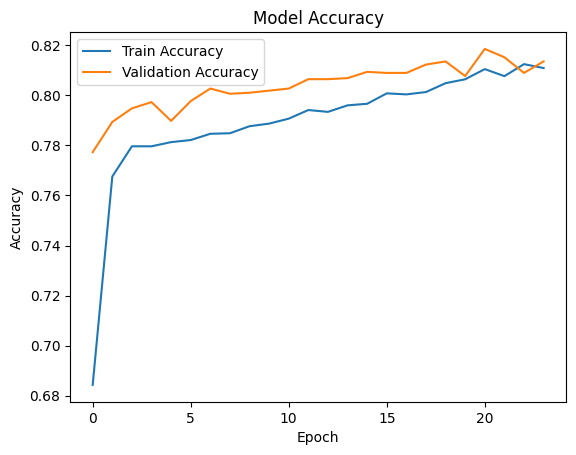

In [17]:
# Step 8: Visualize Training History
# Model's Accuracy evolution durring training
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


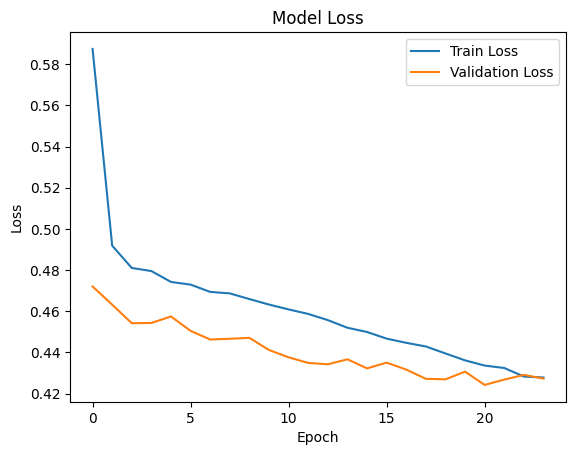

In [18]:
# Model's Loss evolution durring training
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Step 9: Predict Gender for New Names
def predict_gender(model, name, expected_gender=None):
    name = name.lower()  # normalize
    sequence = tokenizer.texts_to_sequences([name])
    padded = pad_sequences(sequence, maxlen=maxlen)
    pred_prob = model.predict(padded)[0][0]
    
    predicted_label = label_encoder.inverse_transform([int(round(pred_prob))])[0]
    print(f"Name: {name.capitalize()} → Predicted Gender: {predicted_label} (Confidence: {pred_prob:.2f}) Expected: {expected_gender} {'' if predicted_label == expected_gender else '!!!'}")
    #return f"{name.capitalize()} → {gender} ({prob:.5f}), expected: {expected_gender}, Result: {'' if gender == expected_gender else '!!!'}"

# Examples
print(predict_gender(model, "Michael", "M"))
print(predict_gender(model, "Michaela", "F"))
print(predict_gender(model, "Sophia", "F"))
print(predict_gender(model, "Liam", "M"))
print(predict_gender(model, "Isabella", "F"))
print(predict_gender(model, "Lucas", "M"))
print(predict_gender(model, "Zoe", "F"))
print(predict_gender(model, "Ana", "F"))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Name: Michael → Predicted Gender: M (Confidence: 0.83) Expected: M 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Name: Michaela → Predicted Gender: F (Confidence: 0.02) Expected: F 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Name: Sophia → Predicted Gender: F (Confidence: 0.07) Expected: F 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Name: Liam → Predicted Gender: M (Confidence: 0.77) Expected: M 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Name: Isabella → Predicted Gender: F (Confidence: 0.00) Expected: F 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Name: Lucas → Predicted Gender: M (Confidence: 0.84) Expected: M 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Name: Zoe → Predicted Gender: M (Confidence: 0.74) Expected: F !!!
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Name: Ana → Predicted Gender: F (Confidence: 0.08) Expected: F 
None


In [20]:

print(predict_gender(model, "Alexa", "F"))
print(predict_gender(model, "Jennie", "F"))
print(predict_gender(model, "Autumn", "F"))
print(predict_gender(model, "Sadie", "F"))
print(predict_gender(model, "Gene", "M"))
print(predict_gender(model, "Sam", "M"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Name: Alexa → Predicted Gender: F (Confidence: 0.07) Expected: F 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Name: Jennie → Predicted Gender: F (Confidence: 0.28) Expected: F 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Name: Autumn → Predicted Gender: M (Confidence: 0.89) Expected: F !!!
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Name: Sadie → Predicted Gender: F (Confidence: 0.18) Expected: F 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Name: Gene → Predicted Gender: F (Confidence: 0.44) Expected: M !!!
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Name: Sam → Predicted Gender: M (Confidence: 0.81) Expected: M 
None


In [21]:
print(predict_gender(model, "Florin", "M"))
print(predict_gender(model, "Florina", "F"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Name: Florin → Predicted Gender: M (Confidence: 0.75) Expected: M 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Name: Florina → Predicted Gender: F (Confidence: 0.02) Expected: F 
None


In [22]:
print(predict_gender(model, "Marian", "M"))
print(predict_gender(model, "Maria", "F"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Name: Marian → Predicted Gender: M (Confidence: 0.73) Expected: M 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Name: Maria → Predicted Gender: F (Confidence: 0.02) Expected: F 
None


In [23]:
print(predict_gender(model, "Marcel", "M"))
print(predict_gender(model, "Marcela", "F"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Name: Marcel → Predicted Gender: M (Confidence: 0.72) Expected: M 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Name: Marcela → Predicted Gender: F (Confidence: 0.02) Expected: F 
None


In [24]:
print(predict_gender(model, "Diego", "M"))
print(predict_gender(model, "Stefan", "M"))
print(predict_gender(model, "Stefania", "F"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Name: Diego → Predicted Gender: M (Confidence: 0.91) Expected: M 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Name: Stefan → Predicted Gender: M (Confidence: 0.82) Expected: M 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Name: Stefania → Predicted Gender: F (Confidence: 0.02) Expected: F 
None


In [25]:
#calculate if these are unseen names, calculate how many are correct 
#do more graphics if needed to better understand the model's performance
# observations =>short names don't perform well, longer names are better
# => "Florina/Florin" or "Michael/Michaela" are good examples, they are 90% similar, 
# it's detecting the diffrence in the last character that indicates the gender
# => Suggestions: run training on a dataset with just these short/ambigous names, try it out (excercise)

In [26]:
# Step 10: Save the model in Keras format
save_filename = "name_gender_model_82_trained_9590_rows.keras"
model.save(save_filename)
#!!!! save the tokenizer and label encoder as well

In [27]:
# Step 11: Load the model and use it

from tensorflow.keras.models import load_model

model2 = load_model(save_filename)

In [28]:
print(predict_gender(model2, "Diego", "M"))
print(predict_gender(model2, "Stefan", "M"))
print(predict_gender(model2, "Stefania", "F"))
print(predict_gender(model2, "Alexa", "F"))
print(predict_gender(model2, "Jennie", "F"))
print(predict_gender(model2, "Autumn", "F"))
print(predict_gender(model2, "Sadie", "F"))
print(predict_gender(model2, "Gene", "M"))
print(predict_gender(model2, "Sam", "M"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Name: Diego → Predicted Gender: M (Confidence: 0.91) Expected: M 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Name: Stefan → Predicted Gender: M (Confidence: 0.82) Expected: M 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Name: Stefania → Predicted Gender: F (Confidence: 0.02) Expected: F 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Name: Alexa → Predicted Gender: F (Confidence: 0.07) Expected: F 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Name: Jennie → Predicted Gender: F (Confidence: 0.28) Expected: F 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Name: Autumn → Predicted Gender: M (Confidence: 0.89) Expected: F !!!
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Name: Sadie → Predicted Gender: F (Confidence: 0.18) Expected: F 
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Name: Gene → Predicted Gender: F (Confidence: 0.44) Expected: M !!!
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Name: Sam → Predicted Gender: M (Confidence: 0.81) Expected: M 
None
